In [1]:
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import scipy.stats as ss
from numpy import ceil, sqrt, exp, log, cos, pi, longfloat, clongfloat, sin
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import trange
from time import perf_counter
import gc

plt.rcParams["figure.figsize"] = (20, 7)
plt.rcParams["font.size"] = 13
plt.style.use('bmh')

blue_shades     = ['#0000FF', '#3399FF', '#66B2FF', '#99CCFF', '#CCE5FF']
green_shades    = ['#005500', '#009900', '#00CC00', '#66FF66', '#99FF99']

import plotly.io as pio
pio.renderers.default = "png"
pio.templates.default = 'plotly'
pio.templates['plotly']['layout'].update(width=1200, height=400)    ; ""

''

----------------------------------------------------------------
# Normal Distribution Density Funciton with Fourier Transform and Characteristic Function

$$\begin{align*}
&f(z) &\approx& \frac{1}{2}A_0 + \sum_{n=1}^{\infty}A_n cos(n\pi\frac{z-a}{b-a}) \\
&A_n     &=\;& \frac{2}{b-a}Re\bigg[ \varphi_z(\frac{n\pi}{b-a}) e^{in\pi\frac{-a}{b-a}} \bigg] \\
&\varphi_X(u) &=\;& e^{iu\mu-\frac{1}{2}\sigma^2u^2}, \quad\text{If $X \sim N(\mu,\sigma^2)$} \\
\end{align*}$$

TODO Future:
- GBM Analytical VS Fourier
- GBM CDF Fourier vs Analytical
- Heston CDF
- Function to calculate N given z: for a range of values
- Function to calculate z given N: for a range of values

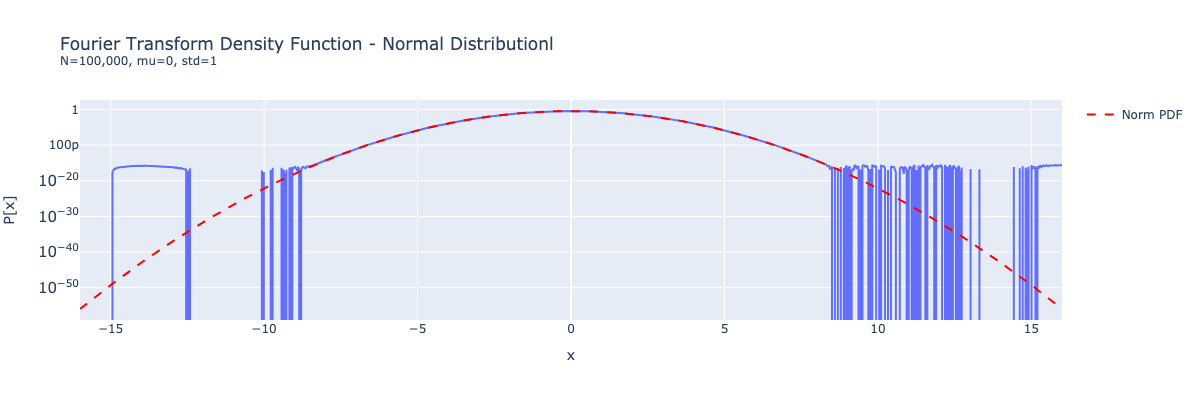

In [2]:
def Fourier_Norm_PDF_char_function(char_function, x:np.array, a, b, N:int):
    A  = lambda n : 2/(b-a) *  np.real( char_function((n*pi)/(b-a))*exp((-1j*n*pi*a)/(b-a))  )
    fx = .5*A(0)
    for n in np.arange(1, N+1):#.astype(np.longfloat):
        fx += A(n) * cos(n*pi * (x-a)/(b-a))#, dtype=(np.longfloat))
    return fx

mu  = 0
std = 1

char_function = lambda u: exp(1j*u*mu -.5*std**2*u**2).astype(clongfloat)
f             = lambda x: ss.norm.pdf(x, loc=mu, scale=std)

Z = lambda z: mu + z * std

z = 16
x   = np.linspace(Z(-z), Z(z), 1_000)

a = Z(-z)
b = Z(z)

N = 100_000
fx = Fourier_Norm_PDF_char_function(char_function, x, a, b, N)
results = pd.DataFrame({'x':x, 'P[x]':fx})
results
fig = px.line(results, x='x', y='P[x]', log_y=1, #color_discrete_sequence=blue_shades,
              title=f'Fourier Transform Density Function - Normal Distributionl<br><sup>N={N:,}, mu={mu}, std={std}</sup>',)
trace2 = go.Scatter(x=x, y=f(x), mode='lines', name='Norm PDF', line=dict(color='red', dash='dash'))    ;   fig.add_trace(trace2)
# fig = go.Scatter(x=x, y=f(x), mode='lines', name='Norm PDF', line=dict(color='red', dash='dash'))
fig.update_layout(hovermode="x unified")
fig.show()

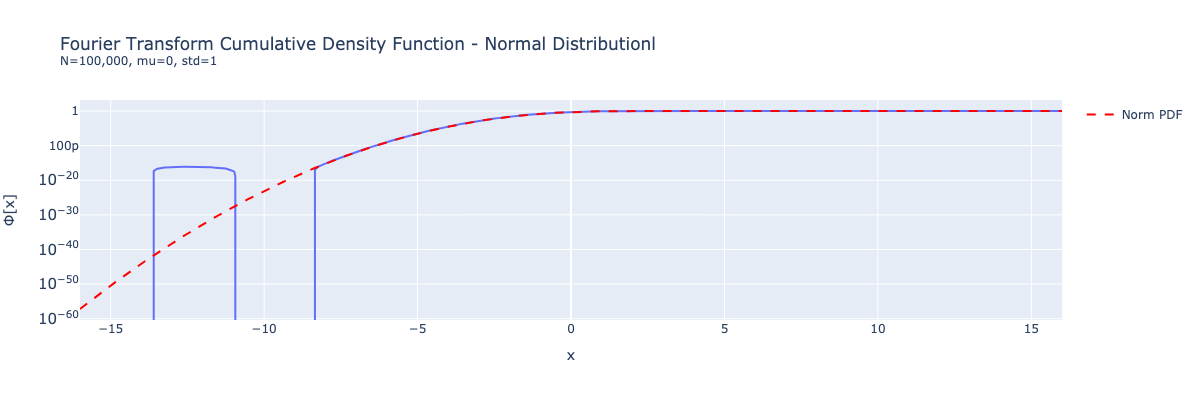

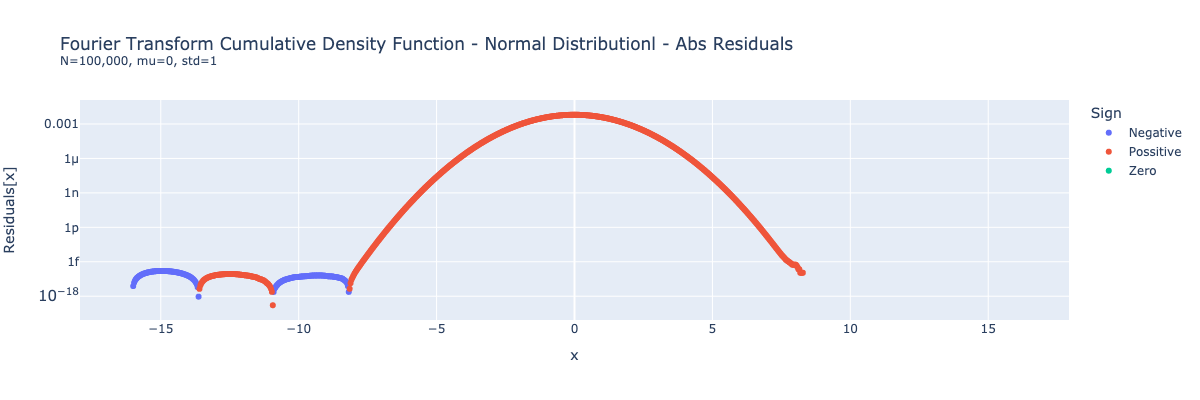

In [3]:
cdf = np.cumsum(fx/np.sum(fx))
cdf_analytical = ss.norm.cdf(x, loc=mu, scale=std)

results = pd.DataFrame({'x':x, 'Φ[x]':cdf})
fig = px.line(results, x='x', y='Φ[x]', log_y=1, #color_discrete_sequence=blue_shades,
              title=f'Fourier Transform Cumulative Density Function - Normal Distributionl<br><sup>N={N:,}, mu={mu}, std={std}</sup>',)
trace2 = go.Scatter(x=x, y=cdf_analytical, mode='lines', name='Norm PDF', line=dict(color='red', dash='dash'))    ;   fig.add_trace(trace2)
fig.update_layout(hovermode="x unified")
fig.show()

sign = []#np.where(np.sign(cdf - cdf_analytical) < )
for e in np.sign(cdf - cdf_analytical):
    if e < 0 : sign.append('Negative')
    elif e == 0 : sign.append('Zero')
    elif e > 0 : sign.append('Possitive')
    
results = pd.DataFrame({'x':x, 'Residuals[x]':(abs(cdf - cdf_analytical)), 'Sign':sign})
fig = px.scatter(results, x='x', y='Residuals[x]', color='Sign', log_y=True, #color_discrete_sequence=blue_shades,
              title=f'Fourier Transform Cumulative Density Function - Normal Distributionl - Abs Residuals<br><sup>N={N:,}, mu={mu}, std={std}</sup>',)
fig.update_layout(hovermode="x unified")
fig.show()

----------------------------------------------------------------
# GBM Density Funciton with Fourier Transform and Characteristic Function

In [4]:
# # ((b-a)*sin(pi*n))/(pi*n)

# sigma = .1
# def char_function(u): # BS Characteristic
#     m       = log(S0) + (r - .5*sigma**2)*(T)
#     return exp(1j * u * m -0.5*(u**2 * sigma**2)*T)

# # ----------------------------------------------------------------------------------------------------------------
# Zs  = [18,24,32,64,128]
# c1 = log(S0) + r*T 
# c2 = sigma**2*T
# E_S_T = exp(log(S0) + r*T ) #+ (1 - exp(-kappa*T))*(theta-v0)/(2*kappa) - (1/2)*theta*T)

# a = c1 - 24*sqrt(abs(c2))
# b = c1 + 24*sqrt(abs(c2))
# S_T = lambda z: exp(c1 + z*sqrt(abs(c2)))

# x   = np.linspace(a, b, 1_000)

# results = []
# T = .1   ;   N = 1_024
# for i, z in enumerate(Zs):
#     a = c1 - z*sqrt(abs(c2))
#     b = c1 + z*sqrt(abs(c2))
#     fx = Fourier_cosine_char_function(char_function=char_function, x=x, a=a, b=b, N=N)
#     results.append(pd.DataFrame({'z':np.full_like(fx,z), 'S(T)':exp(x), 'Pr[S(T)]':fx}))
#     # print(f'z({z}) : Sum(fx)={fx.sum():.2f}, b-a = {exp(b)-exp(a)}')

# results = pd.concat(results)
# fig = px.line(results, x="S(T)", y="Pr[S(T)]", color='z', log_y=0, #color_discrete_sequence=blue_shades,
#               title=f'Fourier Transform Density Function - GBM Model<br><sup>T={T}, N={N:,}, sigma={sigma}</sup>',)
# fig.add_vline(x=E_S_T,      line_width=1, line_dash="dash", line_color="red", annotation_text='E[S(T)]', annotation_position="top")
# fig.add_vline(x=S_T(12),    line_width=1, line_dash="dash", line_color="black", annotation_text='12z', annotation_position="top")
# fig.add_vline(x=S_T(-12),   line_width=1, line_dash="dash", line_color="black", annotation_text='-12z', annotation_position="top")
# fig.add_vline(x=S_T(24),    line_width=1, line_dash="dash", line_color="black", annotation_text='24z', annotation_position="top")
# fig.add_vline(x=S_T(-24),   line_width=1, line_dash="dash", line_color="black", annotation_text='-24z', annotation_position="top")
# fig.update_layout(hovermode="x unified")
# fig.show()
# exp(c1 + 12*sqrt(abs(c2)))

----------------------------------------------------------------
# Heston Density Funciton with Fourier Transform and Characteristic Function

c3 = -1.0196183098088438e-07
cbrt(c3) = -0.004671745851053782
exp(cbrt(c3)) = 0.9953391497797851
exp(c3) = 0.9999998980381742

skew_L = 1.0467174585105379, skew_R = 0.9532825414894622
# z= 6: a,b=(   4187.55,    4634.90), neg=0.00%
# z= 8: a,b=(   4117.31,    4713.97), neg=0.00%
# z=12: a,b=(   3980.34,    4876.19), neg=0.00%
# z=18: a,b=(   3783.39,    5130.03), neg=0.00%
# z=24: a,b=(   3596.17,    5397.10), neg=0.00%
# z=32: a,b=(   3360.89,    5774.93), neg=0.00%
# z=64: a,b=(   2563.94,    7569.95), neg=0.00%
# z=250: a,b=(    531.70,   36503.22), neg=48.59%


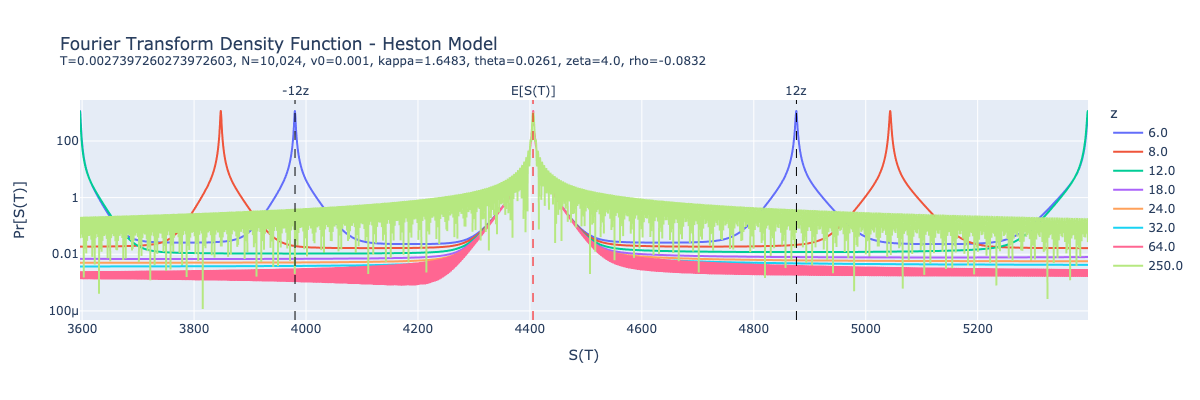

In [5]:
# Heston Model Parameters
v0=0.02177 ; kappa=0.0099 ; theta=0.0946 ; zeta=0.7669 ; rho=-0.3188 
v0=0.02356 ; kappa=1.9024 ; theta=0.0038 ; zeta=1.4670 ; rho=-0.5821 
v0=0.001 ; kappa=1.6483 ; theta=0.0261 ; zeta=4.0000 ; rho=-0.0832
S0=4405.71 ; r=0.0000 ; T=1/365
# v0=0.01  ; kappa=1  ; theta=0.01  ; zeta=10 ; rho=-.6

def Fourier_cosine_char_function(char_function, x:np.array, a, b, N:int):
    A  = lambda n : 2/(b-a) *  np.real( char_function((n*pi)/(b-a))*exp((-1j*n*pi*a)/(b-a))  )
    fx = .5*A(0)
    for n in np.arange(1, N+1):#.astype(np.longfloat):
        fx += A(n) * cos(n*pi * (x-a)/(b-a))#, dtype=(np.longfloat))
    return fx

def char_function(u): # Heston Characteristic
    t0 = 0.0 ;  q = 0.0
    m = log(S0) + (r - q)*(T-t0)
    D = sqrt((rho*zeta*1j*u - kappa)**2 + zeta**2*(1j*u + u**2))
    C = (kappa - rho*zeta*1j*u - D) / (kappa - rho*zeta*1j*u + D)
    beta = ((kappa - rho*zeta*1j*u - D)*(1-exp(-D*(T-t0)))) / (zeta**2*(1-C*exp(-D*(T-t0))))
    alpha = ((kappa*theta)/(zeta**2))*((kappa - rho*zeta*1j*u - D)*(T-t0) - 2*log((1-C*exp(-D*(T-t0))/(1-C))))
    return exp(1j*u*m + alpha + beta*v0)

# ----------------------------------------------------------------------------------------------------------------
Zs  = [6,8,12,18,24,32,64,250]
E_S_T = exp(log(S0) + r*T ) #+ (1 - exp(-kappa*T))*(theta-v0)/(2*kappa) - (1/2)*theta*T)
c1 = log(S0) + r*T + (1 - exp(-kappa*T))*(theta-v0)/(2*kappa) - (1/2)*theta*T
c2 = (
    (1/(8*kappa**3)) * (zeta*T*kappa*exp(-kappa*T)*(v0-theta)*(8*kappa*rho-4*zeta)
    + kappa*rho*zeta*(1-exp(-kappa*T))*(16*theta-8*v0)
    + 2*theta*kappa*T*(-4*kappa*rho*zeta + zeta**2 + 4*kappa**2)
    + zeta**2*((theta - 2*v0)*exp(-2*kappa*T) + theta*(6*exp(-kappa*T)-7) + 2*v0)
    + 8*kappa**2*(v0-theta)*(1-exp(-kappa*T)))
)
c1 = log(S0) + r*T - .5*theta*T
c2 = theta/(8*kappa**3)*(-zeta**2*exp(-2*kappa*T) + 4*zeta*exp(-kappa*T)*(zeta-2*kappa*rho) 
        + 2*kappa*T*(4*kappa**2 + zeta**2 - 4*kappa*zeta*rho) + zeta*(8*kappa*rho - 3*zeta)
        )
c3 = (zeta*theta)/(8*kappa**5)*(
    zeta**3*exp(-3*kappa*T) - 3*kappa*zeta*exp(-2*kappa*T)*(-zeta*T*(zeta-2*kappa*rho) - 2*(kappa-zeta*rho)) 
    - 3*exp(-kappa*T)*(2*kappa*zeta*T*(zeta-2*kappa*rho)**2 + 3*zeta**3 - 8*kappa**3*rho - 16*kappa*zeta**2*rho + 8*kappa**2*zeta*(1+2*rho**2))
    + 3*kappa*T*(-zeta**3 + 8*kappa**3*rho + 6*kappa*zeta**2*rho - 4*kappa**2*zeta*(1+2*rho**2)) 
    + 8*zeta**3 - 24*kappa**3*rho - 42*kappa*zeta**2*rho + 6*kappa**2*zeta*(3+8*rho**2)
)
print(f"""c3 = {c3}
cbrt(c3) = {np.cbrt(c3)}
exp(cbrt(c3)) = {exp(np.cbrt(c3))}
exp(c3) = {exp(c3)}
""")
z = 24
a = c1 - z*sqrt(abs(c2))
b = c1 + z*sqrt(abs(c2))
skew_L, skew_R = 1-10*np.cbrt(c3) , 1+10*np.cbrt(c3)
print(f'skew_L = {skew_L}, skew_R = {skew_R}')

S_T = lambda z: exp(c1 + z*sqrt(abs(c2)))

x   = np.linspace(a, b, 10_000)

results = []
T = 1/365  ;   N = 10_024
for i, z in enumerate(Zs):
    a = c1 - skew_L*z*sqrt(abs(c2)) 
    b = c1 + skew_R*z*sqrt(abs(c2)) 
    a = c1 - z*sqrt(abs(c2)) 
    b = c1 + z*sqrt(abs(c2)) 
    fx = Fourier_cosine_char_function(char_function=char_function, x=x, a=a, b=b, N=N)
    print(f'# z={z:2.0f}: a,b=({exp(a):10.2f}, {exp(b):10.2f}), neg={np.where(fx<0,1,0).mean()*100:.2f}%')
    results.append(pd.DataFrame({'z':np.full_like(fx,z), 'S(T)':exp(x), 'Pr[S(T)]':fx}))

results = pd.concat(results)
fig = px.line(results, x="S(T)", y="Pr[S(T)]", color='z', log_y=1, #color_discrete_sequence=blue_shades,
              title=f'Fourier Transform Density Function - Heston Model<br><sup>T={T}, N={N:,}, v0={v0}, kappa={kappa}, theta={theta}, zeta={zeta}, rho={rho}</sup>',)
fig.add_vline(x=exp(c1),      line_width=1, line_dash="dash", line_color="red", annotation_text='E[S(T)]', annotation_position="top")
fig.add_vline(x=S_T(12),    line_width=1, line_dash="dash", line_color="black", annotation_text='12z', annotation_position="top")
fig.add_vline(x=S_T(-12),   line_width=1, line_dash="dash", line_color="black", annotation_text='-12z', annotation_position="top")
fig.update_layout(hovermode="x unified")
fig.show()

# Deductions
## Quality - Continuity
- the higher the v0 relative to theta the more stable the results
- higher kappa leads to better results
- higher zeta leads to more unstable results
- rho does not affect the stability of the results

## Skewness
- rho skews the distribution of S_T to the left (for negative values) and to the right (for positive values)

## Limits
- z should be a function of the cumulants ?

## Quesitons
- for what paramters a z value is unstable?
- why higher (stable) z values make better results in the bigger values of the distribution?

**Paper with Cumulants**
https://arxiv.org/pdf/0909.3978.pdf


## Heston Model - Formula
$$\begin{align*}
& dS_t      &=\;& (r-q) S_t dt + \sqrt{\nu_t}S_t dW_t^S, \\
& d\nu_t    &=\;& \kappa(\theta - \nu_t)dt + \zeta \sqrt{\nu_t}dW_t^\nu \\
& \rho dt   &=\;& dW_t^S dW_t^\nu \\
\\
& \nu_0, &=\;& \text{The initial variance} \\
& \kappa, &=\;& \text{The speed of the mean reversion} \\
& \theta, &=\;& \text{The long term mean variance} \\
& \zeta, &=\;& \text{The volatility of the volatility "vol of vol"} \\
& \rho, &=\;& \text{The correlation of the two Weiner proceses} \\
\end{align*}$$